In [22]:
import glob
import csv
import re
import pandas as pd
import itertools
import numpy as np
from tqdm.notebook import tqdm
import csv
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns 
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
from tqdm.notebook import tqdm

import sklearn
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import metrics
from scipy import stats

import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from tensorflow import keras
from tensorflow.keras import layers

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolfiles, Descriptors, rdchem

In [2]:
quints_fps = pd.read_csv("output/quints_fps.csv", header=None)
quints_infos = pd.read_csv("output/quints_infos.csv", names=["set", "pertname", "pertsmarts", "num_ha", "sem"])

quints_whole_df = pd.concat([quints_infos, quints_fps], axis=1)

# drop faulty perturbations (n=66) that required sanitisation pre simulation. FE wrong because of atom mapping mistakes.
exclude_perts = [pert[0] for pert in pd.read_csv("to_do_sims/mapping_mismatches.csv", header=None).values.tolist()]

# extend list with inverse perts, we want to remove those as well.
inv_perts_to_exlude = []
for pert in exclude_perts:
    inv_perts_to_exlude.append(pert.split("~")[1]+"~"+pert.split("~")[0]) 
for pert in inv_perts_to_exlude:
    exclude_perts.append(pert)

quints_whole_df = quints_whole_df[~quints_whole_df['pertname'].isin(exclude_perts)]

In [3]:
# drop NaN columns (happens with molprop generation where (error) strings can't be subtracted)
quints_whole_df = quints_whole_df.dropna(axis=1)

# drop rows where SEM == 0.0. It seems some very large perturbations get this value too, so makes training noisy.
quints_whole_df = quints_whole_df[quints_whole_df["sem"] > 0.0001]

# drop columns where all values are 0.
quints_whole_df = quints_whole_df.loc[:, (quints_whole_df != 0).any(axis=0)]

# TMP DROP DUPLICATES --> should be fewer duplicates when we move up to more features.
quints_whole_df = quints_whole_df.drop_duplicates(subset=quints_whole_df.columns.difference(['sem','set','pertname','pertsmarts']))

quints_whole_df.sort_values(by="sem")

,set,pertname,pertsmarts,num_ha,sem,1,4,5,8,10,...,71,72,73,74,75,77,78,79,80,81
853,TrainingSet,mobley_2802855~mobley_1563176,[C*]Br~[C*]S,1,0.006843,0,1,0,0,0,...,-0.4651,0.0590,38.80,0.0,0.000000,-45.938441,-3.710128,0,0,0.0
852,TrainingSet,mobley_1563176~mobley_2802855,[C*]S~[C*]Br,1,0.006843,0,-1,0,0,0,...,0.4651,-0.0590,-38.80,0.0,0.000000,45.938441,3.710128,0,0,0.0
4209,TrainingSet,mobley_5571660~mobley_1755375,[C*]N~[C*]O,1,0.008176,-1,-1,0,0,0,...,0.0336,-1.9686,-5.79,0.0,0.000000,0.984016,0.234955,0,0,0.0
4208,TrainingSet,mobley_1755375~mobley_5571660,[C*]O~[C*]N,1,0.008176,1,1,0,0,0,...,-0.0336,1.9686,5.79,0.0,0.000000,-0.984016,-0.234955,0,0,0.0
1818,TrainingSet,mobley_186894~mobley_7708038,[C*]S~[C*]Br,1,0.010947,0,-1,0,0,0,...,0.4651,-0.0590,-38.80,0.0,0.000000,45.938441,4.752242,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,TrainingSet,mobley_1189457~mobley_1036761,[C*]SC~[CH*]N,2,24.103939,1,-2,-1,0,-1,...,-1.4043,-9.3276,0.72,0.0,0.000000,-30.976822,-0.957561,-22,-2,-4.0
2670,TrainingSet,mobley_1571523~mobley_2763835,[C*]C.[C*]C~[O*]CC,3,25.098582,0,0,0,0,0,...,0.5522,0.3132,-11.00,-1.0,-1.111111,0.000000,0.000000,12,-3,-4.0
2671,TrainingSet,mobley_2763835~mobley_1571523,[O*]CC~[C*]C.[C*]C,3,25.098582,0,0,0,0,0,...,-0.5522,-0.3132,11.00,1.0,1.111111,0.000000,0.000000,-12,3,4.0
4216,TrainingSet,mobley_2043882~mobley_6175884,[C*]C~[C*]C,1,26.331465,0,0,0,0,0,...,-0.1425,-0.0480,0.00,0.5,0.000000,0.000000,0.000000,2,0,0.0


## discretize

In [14]:
### TMP DISCRETIZE BY STRATIFICATION:
n_bins=10

binned_sem = pd.qcut(quints_whole_df["sem"], n_bins, labels=False)
bin_means = []
quints_whole_df["sem_bin"] = binned_sem
print("Bin, Min, Max, Volume")
for n_bin, df_group in quints_whole_df.groupby(by="sem_bin"):
    print(n_bin, round(min(df_group["sem"].values), 2), round(max(df_group["sem"].values), 2), len(df_group))
    bin_means.append(np.mean(df_group["sem"].values))

Bin, Min, Max, Volume
0 0.01 0.05 328
1 0.05 0.07 326
2 0.07 0.09 326
3 0.09 0.11 325
4 0.11 0.13 328
5 0.13 0.16 326
6 0.16 0.2 326
7 0.2 0.3 326
8 0.3 0.64 326
9 0.64 26.33 326


In [15]:
quints_fps = quints_whole_df.drop(["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"], axis=1)
quints_fps = quints_fps.values
quints_infos = quints_whole_df[["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"]]

## Split

In [16]:
def takeSubset(indices, quints_whole_df):
    """Take a selection of a dataframe using indices"""
    subset = quints_whole_df.iloc[indices]
    
    return subset

def takeInfo(perts_df):
    """from the input dataframe, return arrays of fingerprints and SEMs"""
    sems = perts_df[["sem_bin", "sem"]].values
    
    # fps is a bit more involved. Remove everything but the FP columns, return as 2d array.
    fps_df = perts_df.drop(["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"], axis=1)
    fps = fps_df.values

    return fps, sems

In [26]:
def preProcessSet(train):
    """standardises and reduces dimensionality to 95% VE; returns arrays"""
    
    #### fit the scaler on training set.
    scaler = preprocessing.StandardScaler()
    train_scaled = scaler.fit_transform(train)
    
   
    #### fit PCA on training set with 95% variance explained.
    pca = PCA(n_components=0.95)
    train_preprocessed = pca.fit_transform(train_scaled)
    
    
    return train_preprocessed, scaler, pca

In [27]:
## TMP RANDOM SPLIT INSTEAD OF TSNE SPLIT
from sklearn.model_selection import train_test_split
whole_set, whole_set_sem_bins = takeInfo(takeSubset(np.array(range(len(quints_whole_df))), quints_whole_df))

# preprocess.
whole_set, scaler, pca = preProcessSet(whole_set)

# split
split = 0.2
train_set, test_set1, train_sems, upper_test_sems = train_test_split(whole_set, whole_set_sem_bins, test_size=split, random_state=42)

# save scaler and pca so that we can apply to test set.
pickle.dump(scaler, open("output/scaler.pkl".format(i), 'wb'))
pickle.dump(pca, open("output/pca.pkl".format(i), 'wb'))

# adjust label arrays such that we train on classes, but keep the actual SEM values for later.
train_sems_values = train_sems[:,1]
train_sems = train_sems[:,0]

upper_test_sems_values = upper_test_sems[:,1]
upper_test_sems = upper_test_sems[:,0]

n_classes = len(set(train_sems))

In [28]:
from sklearn.ensemble import RandomForestClassifier
grid_predictions = np.empty((len(test_set1),n_classes))



In [29]:
for i in tqdm(range(25)):
    hyperparams={'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1200}
                            
    forest = RandomForestClassifier(**hyperparams)
    forest.fit(np.array(train_set), np.array(train_sems))
    predicted_probas = forest.predict_proba(test_set1) 
    grid_predictions += predicted_probas

    pickle.dump(forest, open("output/rf_{}.pkl".format(i), 'wb'))

Acc: 0.15926493108728942
Tau: 0.23093811203702744


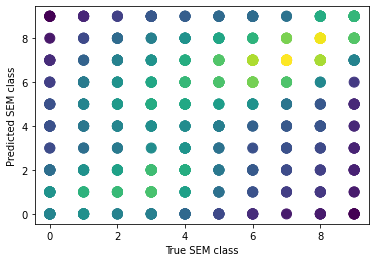

In [30]:
# for preds, true in zip(grid_predictions, upper_test_sems):
#     print(preds, int(true))
model_preds = [np.argmax(pred) for pred in grid_predictions]
print("Acc:", metrics.accuracy_score(upper_test_sems, model_preds))
print("Tau:", stats.kendalltau(upper_test_sems, model_preds)[0])
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([upper_test_sems, model_preds])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots()
ax.scatter(upper_test_sems, model_preds, c=z, s=100, edgecolor=None)
plt.xlabel("True SEM class")
plt.ylabel("Predicted SEM class")
plt.show()